In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
%matplotlib inline

# Load dataset

In [151]:
dataset = pd.read_csv('dataset/dev1_works_distance_dataset.csv')
y = dataset['label'].values
features = dataset.columns.difference(['label'])
X = dataset[features].values
dataset.head()

,publisher.publisher_name,publisher.place_of_publication,publication_type,country_of_publication,language,contributor.name,contributor.role,title,idno,idno.type,subject,publishing_work_items.value,publishing_work_items.type,publishing_work_items.unit,label
0,0.512195,0.590909,0.750,0.714286,0.727273,0.789474,0.789474,0.816327,0.894737,0.645161,0.600000,0.866667,0.862069,0.862069,0
1,0.000000,0.000000,0.125,0.000000,0.000000,0.812500,0.142857,0.000000,0.277778,0.375000,0.000000,0.000000,0.000000,0.000000,0
2,0.457447,0.418605,0.000,0.000000,0.333333,0.880000,0.142857,0.000000,0.352941,0.318182,0.922078,0.619048,0.000000,0.000000,0
3,0.404255,0.515152,0.000,0.250000,0.333333,0.391304,0.200000,0.090909,0.487179,0.444444,0.000000,0.428571,0.000000,0.000000,0
4,0.019608,0.666667,0.000,0.333333,0.000000,0.800000,0.142857,0.000000,0.261538,0.277778,0.000000,0.333333,0.142857,0.142857,0


## Split dataset by label (match|not_match) for visualisation

In [152]:
dataset_matched = dataset[dataset['label']==1]
dataset_not_matched = dataset[dataset['label']==0]

In [153]:
print(sum(dataset_matched[features].mean()))
print(sum(dataset_not_matched[features].mean()))

1.61690406007
2.59288067289


In [154]:
def broken_plot(dataset, column, axis0_limits, axis1_limits, num_bins):
    f, axis = plt.subplots(2, 1, sharex=True)
    axis[0].hist(dataset[[column]].values, num_bins, alpha=0.5)
    axis[1].hist(dataset[[column]].values, num_bins, alpha=0.5)
    axis[0].set_ylim(axis0_limits[0], axis0_limits[1])
    axis[1].set_ylim(axis1_limits[0], axis1_limits[1])

    axis[0].spines['bottom'].set_visible(False)
    axis[1].spines['top'].set_visible(False)
    axis[0].xaxis.tick_top()
    axis[0].tick_params(labeltop='off')
    axis[1].xaxis.tick_bottom()
    d = .015
    kwargs = dict(transform=axis[0].transAxes, color='k', clip_on=False)
    axis[0].plot((-d,+d),(-d,+d), **kwargs)
    axis[0].plot((1-d,1+d),(-d,+d), **kwargs)
    kwargs.update(transform=axis[1].transAxes)
    axis[1].plot((-d,+d),(1-d,1+d), **kwargs)
    axis[1].plot((1-d,1+d),(1-d,1+d), **kwargs)

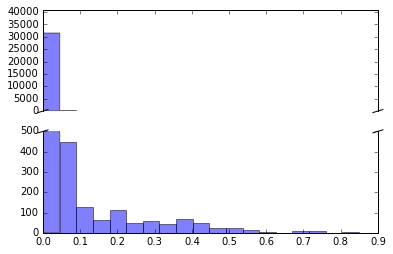

In [155]:
broken_plot(dataset, 'title', (20, 41000), (0, 500), 20)

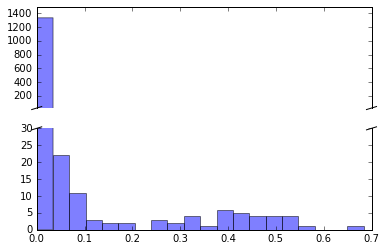

In [156]:
broken_plot(dataset_matched, 'title', (20, 1500), (0, 30), 20)

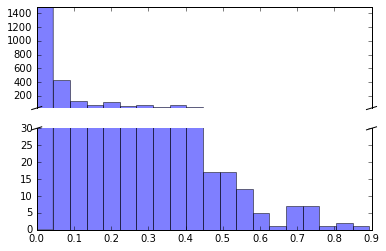

In [157]:
broken_plot(dataset_not_matched, 'title', (20, 1500), (0, 30), 20)

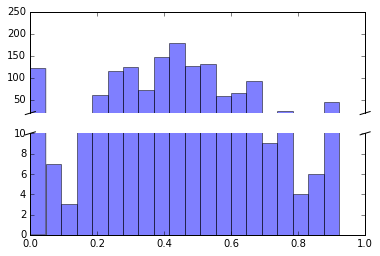

In [158]:
broken_plot(dataset_matched, 'idno', (20, 250), (0, 10), 20)

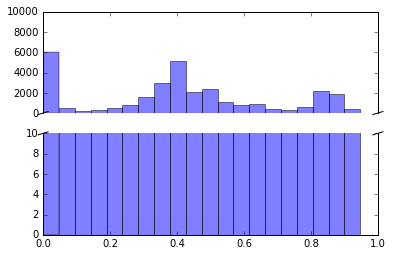

In [159]:
broken_plot(dataset_not_matched, 'idno', (20, 10000), (0, 10), 20)

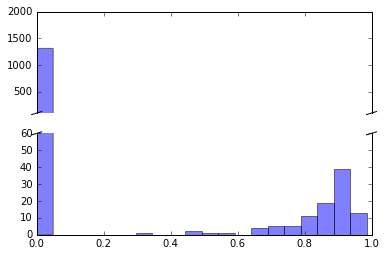

In [160]:
broken_plot(dataset_matched, 'subject', (100, 2000), (0, 60), 20)

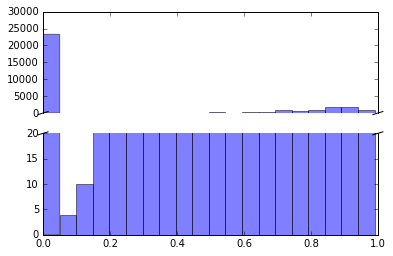

In [161]:
broken_plot(dataset_not_matched, 'subject', (20, 30000), (0, 20), 20)

# Applying classification

## Splitting dataset to train and test

In [162]:
cv_data, test_data, cv_output, test_output = train_test_split(X, y, test_size=0.2, random_state=42)
train_data, validation_data, train_output, validation_output = train_test_split(cv_data, cv_output, test_size=0.4, random_state=42)

In [163]:
model = linear_model.LogisticRegression()
model.fit(train_data, train_output)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [164]:
model_features = pd.DataFrame(np.zeros((len(features), 2)), columns=['features', 'coeff'])
model_features['features'] = features
model_features['coeff'] = model.coef_[0]

In [165]:
model_features

,features,coeff
0,contributor.name,0.443291
1,contributor.role,-1.048183
2,country_of_publication,-2.994818
3,idno,4.834248
4,idno.type,-4.305336
5,language,3.098696
6,publication_type,-5.630889
7,publisher.place_of_publication,-1.351277
8,publisher.publisher_name,0.280481
9,publishing_work_items.type,-2.505069


In [166]:
model.score(validation_data, validation_output)

0.95737956134469882

In [147]:
from sklearn import metrics
predictions = model.predict(validation_data)
fpr, tpr, thresholds = metrics.roc_curve(validation_output, predictions)
metrics.auc(fpr, tpr)

0.51708187645687653

In [169]:
metrics.precision_score(validation_output, predictions)

ValueError: Found arrays with inconsistent numbers of samples: [ 6526 10441]

In [168]:
true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
for y, y_hat in zip(validation_output, predictions):
    if y == y_hat:
        if y_hat == 1:
            true_positive += 1
        else:
            true_negative += 1
    else:
        if y_hat == 1:
            false_positive += 1
        else:
            false_negative += 1
print('true_positive: %s' % true_positive)
print('true_negative: %s' % true_negative)
print('false_positive: %s' % false_positive)
print('false_negative: %s' % false_negative)

true_positive: 0
true_negative: 6249
false_positive: 15
false_negative: 262
